# QECSIM Documentation and Examples 

### QEC SIM :
Python 3 package to simulate quantum error correction using stabilizer codes.
It is lightweight, modular and extensible( allowing additional codes to be added), and we can also modify or even plug in own error models and decoders(for syndrome measurements)

#### Three key abstract classes:  
1. *qecsim.model.StabilizerCode*:Contains syntax for working with various stabilizer codes and logical subspaces
2. *qecsim.model.ErrorModel* : Encodes a error model via a probability distribution function. (modular)
3. *qecsim.model.Decoder* : Class contains objects for syndrome measurements. 


Important syntax aside from classes : 
* Error_probability : Input feeded to our probability distribution function. Error probability to be float in [0, 1].
* qecsim.app.run_once(code, error_model, decoder, error_probability, rng=None) : Run the final circuit with all classes



* Binary Symplectic Form $A\circ B$ is given by A.I.B ;  Here I = Tensor with (Identity on diagonal elements)
Pauli Operators (Stabilizers, logical operators and recovery operators) are represented in Binary Symplectic form
It is means of representing elements of the Pauli group (neglecting global phases) using binary vectors a and b such that an element P of the Pauli group acting on n qubits is $X^{a}Z^{b} = X^{a_1}Z^{b_1}
\otimes \ldots \otimes X^{a_n}Z^{b_n}$.
E.g.  
1. numpy.array([0, 0, 1, 1, 0, 1, 1, 0]) = [0 0 1 1 | 0 1 1 0] = IZYX
2. numpy.array([0, 1, 0, 1, 1, 1, 0, 0]) = [0 1 0 1 | 1 1 0 0] = ZYIX

Symplectic form denoting action of Pauli operators on 4 qubits. Library contained in *qecsim.paulitools*




#### Flowchart of Simulation : 
* We generate random Pauli error by passing code and *error_probability* to *qecsim.model.ErrorModel.generate()*.
* Run the required stabilizer code by *qecsim.model.StabilizerCode*, which contains built in stabilizer codes. 
* $A\circ B$
* evaluate syndrome as *error* ⊙ *code.stabilizers$^T$* 
* generate step_measurement_errors[t] as syndrome bit-flips.
* Finally calculate, syndrome[t] as step_measurement_errors[t-1] ⊕ step_syndromes[t] ⊕ step_measurement_errors[t].
* evaluate error as ⨁ step_errors (all t values)
* All this is internaly resolved decoding by passing code, time_steps and syndrome to qecsim.model.DecoderFTP.decode_ftp().
* Finally, define recovered as decoding ⊕ error






In [7]:
#Utility function for better coLoured and formatted results, from IPython.display import HTML

# namespace
class qsu:
    
    @staticmethod
    def print_pauli(pauli):
        text = str(pauli)
        text = text.replace('X', '<span style="color:red; font-weight:bold">X</span>')
        text = text.replace('Y', '<span style="color:magenta; font-weight:bold">Y</span>')
        text = text.replace('Z', '<span style="color:blue; font-weight:bold">Z</span>')
        display(HTML('<div class="highlight"><pre style="line-height:1!important;">{}</pre></div>'.format(text))) 

In [11]:
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import DepolarizingErrorModel, NaiveDecoder
from qecsim.models.basic import FiveQubitCode

# initialise models
my_code = FiveQubitCode()
my_error_model = DepolarizingErrorModel()
my_decoder = NaiveDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)


FiveQubitCode()
DepolarizingErrorModel()
NaiveDecoder(10)


In [12]:
# set physical error probability to 10%
error_probability = 0.1
# seed random number generator for repeatability
rng = np.random.default_rng(8)

# error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
qsu.print_pauli('error: {} {}'.format(error, pt.bsf_to_pauli(error)))


NameError: name 'HTML' is not defined

The syndrome is a binary array indicating the stabilizers with which the error does not commute. It is calculated as syndrome=error⊙stabilisers$^T$.



In [13]:
# syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
print('syndrome: {}'.format(syndrome))


syndrome: [0 1 0 1]


Recovery operation :
In this case, the recovery operation is found by using a naive decoder that iterates through all possible Pauli operations, in ascending weight, until it finds a recovery operation that gives the same syndrome as the random error, i.e. recovery⊙stabilisers$^T$=syndrome

In [14]:
# recovery: best match recovery operation based on decoder
recovery = my_decoder.decode(my_code, syndrome)
qsu.print_pauli('recovery: {} {}'.format(recovery, pt.bsf_to_pauli(recovery)))


NameError: name 'HTML' is not defined

As a sanity check, we expect (recovery ⊕ error) to commute with all stabilizers, i.e. (recovery ⊕ error) ⊙ stabilisers$^T$=0.



In [15]:
# check recovery ^ error commutes with stabilizers (by construction)
print(pt.bsp(recovery ^ error, my_code.stabilizers.T))


[0 0 0 0]


##### Recovery Operation
The recovery operation is successful iff recovery⊕error commutes with all logical operators, i.e. (recovery⊕error) ⊙ logicals$^T$=0.



In [16]:
# success iff recovery ^ error commutes with logicals
print(pt.bsp(recovery ^ error, my_code.logicals.T))


[0 0]


### Steane Code :

In [17]:
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import DepolarizingErrorModel, NaiveDecoder
from qecsim.models.basic import SteaneCode

# initialise models
my_code = SteaneCode()
my_error_model = DepolarizingErrorModel()
my_decoder = NaiveDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)


SteaneCode()
DepolarizingErrorModel()
NaiveDecoder(10)


In [18]:
# set physical error probability to 10%
error_probability = 0.1
# seed random number generator for repeatability
rng = np.random.default_rng(8)

# error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
qsu.print_pauli('error: {} {}'.format(error, pt.bsf_to_pauli(error)))


NameError: name 'HTML' is not defined

In [19]:
# syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
print('syndrome: {}'.format(syndrome))


syndrome: [0 1 0 0 0 0]


In [20]:
# recovery: best match recovery operation based on decoder
recovery = my_decoder.decode(my_code, syndrome)
qsu.print_pauli('recovery: {} {}'.format(recovery, pt.bsf_to_pauli(recovery)))


NameError: name 'HTML' is not defined

In [21]:
# check recovery ^ error commutes with stabilizers (by construction)
print(pt.bsp(recovery ^ error, my_code.stabilizers.T))


[0 0 0 0 0 0]


In [22]:
# success iff recovery ^ error commutes with logicals
print(pt.bsp(recovery ^ error, my_code.logicals.T))


[0 0]


## Comparison of Steane vs Five-Qubit Code : 
Plot statistics on many error correction simulation runs

In [23]:
%matplotlib inline
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from qecsim import app
from qecsim.models.generic import DepolarizingErrorModel, NaiveDecoder
from qecsim.models.basic import FiveQubitCode, SteaneCode

# set models
codes = [FiveQubitCode(), SteaneCode()]
error_model = DepolarizingErrorModel()
decoder = NaiveDecoder()
# set physical error probabilities
error_probability_min, error_probability_max = 0, 0.5
error_probabilities = np.linspace(error_probability_min, error_probability_max, 20)
# set max_runs for each probability
max_runs = 10000

# print run parameters
print('Codes:', [code.label for code in codes])
print('Error model:', error_model.label)
print('Decoder:', decoder.label)
print('Error probabilities:', error_probabilities)


Codes: ['5-qubit', 'Steane']
Error model: Depolarizing
Decoder: Naive
Error probabilities: [0.         0.02631579 0.05263158 0.07894737 0.10526316 0.13157895
 0.15789474 0.18421053 0.21052632 0.23684211 0.26315789 0.28947368
 0.31578947 0.34210526 0.36842105 0.39473684 0.42105263 0.44736842
 0.47368421 0.5       ]


In [24]:
# run simulations and print data from middle run to view format
data = [app.run(code, error_model, decoder, error_probability, max_runs=max_runs)
        for code in codes for error_probability in error_probabilities]
print(data[len(data)//2])


{'code': 'Steane', 'n_k_d': (7, 1, 3), 'time_steps': 1, 'error_model': 'Depolarizing', 'decoder': 'Naive', 'error_probability': 0.0, 'measurement_error_probability': 0.0, 'n_run': 10000, 'n_success': 10000, 'n_fail': 0, 'n_logical_commutations': (0, 0), 'custom_totals': None, 'error_weight_total': 0, 'error_weight_pvar': 0, 'logical_failure_rate': 0.0, 'physical_error_rate': 0.0, 'wall_time': 3.203084200000035}


In [25]:
#prepare code to x,y map and print
code_to_xys = {}
for run in data:
    xys = code_to_xys.setdefault(run['code'], [])
    xys.append((run['physical_error_rate'], run['logical_failure_rate']))
print('\n'.join('{}: {}'.format(k, v) for k, v in code_to_xys.items()))


5-qubit: [(0.0, 0.0), (0.02478, 0.0064), (0.05062, 0.0224), (0.0788, 0.0551), (0.10507999999999999, 0.0837), (0.13012, 0.1265), (0.16094, 0.1801), (0.18448, 0.2173), (0.2116, 0.2739), (0.23942, 0.3246), (0.264, 0.3656), (0.28858, 0.4138), (0.3158, 0.456), (0.34296, 0.5015), (0.36816, 0.5476), (0.39726, 0.5879), (0.42282, 0.6126), (0.4468, 0.6383), (0.47413999999999995, 0.6649), (0.50154, 0.6888)]
Steane: [(0.0, 0.0), (0.026042857142857145, 0.0103), (0.05237142857142857, 0.0371), (0.0786, 0.0762), (0.10514285714285714, 0.1236), (0.1324, 0.1776), (0.15584285714285714, 0.2255), (0.18272857142857143, 0.2895), (0.2099285714285714, 0.3412), (0.23742857142857143, 0.4043), (0.26334285714285716, 0.4479), (0.29188571428571425, 0.4928), (0.31605714285714287, 0.5412), (0.3452, 0.5705), (0.3664428571428572, 0.6001), (0.39772857142857143, 0.6321), (0.41914285714285715, 0.6597), (0.4486285714285715, 0.687), (0.4698142857142857, 0.6987), (0.49925714285714284, 0.7148)]


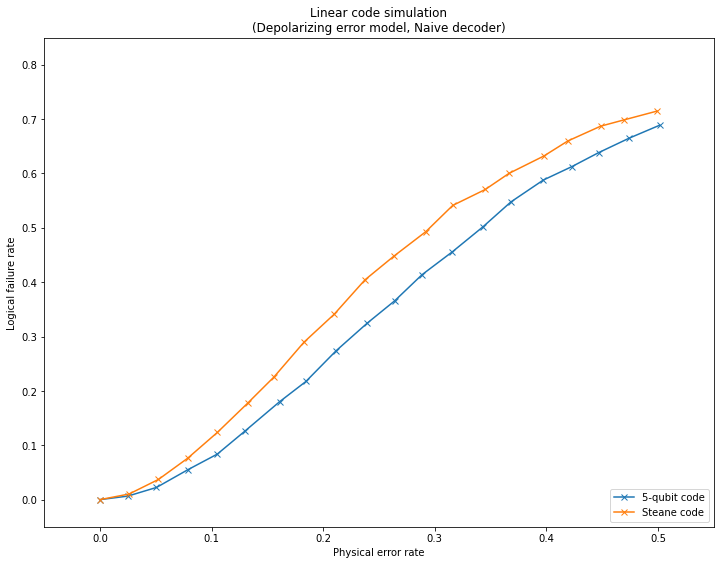

In [26]:
# format plot
fig = plt.figure(1, figsize=(12, 9))
plt.title('Linear code simulation\n({} error model, {} decoder)'.format(error_model.label, decoder.label))
plt.xlabel('Physical error rate')
plt.ylabel('Logical failure rate')
plt.xlim(error_probability_min-0.05, error_probability_max+0.05)
plt.ylim(-0.05, 0.85)
# add data
for code, xys in code_to_xys.items():
    plt.plot(*zip(*xys), 'x-', label='{} code'.format(code))
plt.legend(loc='lower right')
plt.show()


## Surface Code Sim : 

In [27]:
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import DepolarizingErrorModel
from qecsim.models.planar import PlanarCode, PlanarMWPMDecoder

# initialise models
my_code = PlanarCode(5, 5)
my_error_model = DepolarizingErrorModel()
my_decoder = PlanarMWPMDecoder()
# print models
print(my_code)
print(my_error_model)
print(my_decoder)


PlanarCode(5, 5)
DepolarizingErrorModel()
PlanarMWPMDecoder()


In [28]:
# set physical error probability to 10%
error_probability = 0.1
# seed random number generator for repeatability
rng = np.random.default_rng(59)

# error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
qsu.print_pauli('error:\n{}'.format(my_code.new_pauli(error)))


NameError: name 'HTML' is not defined

In [ ]:
# syndrome as stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
qsu.print_pauli(format(my_code.ascii_art(syndrome)))
